<h1>SER-347 - Introdução à Programação para Sensoriamento Remoto </h1>
<br>


<h1>Classificação simultânea de diferentes imagens - trabalho final </h1>


<br>

### Maria Antônia Falcão de Oliveira

O presente trabalho teve por objetivo elaborar um programa capaz de realizar cálculos a partir da discriminação de classes por meio do algoritmo de Máxima Verossimilhança e classificar diferentes imagens simultaneamente.

<img src="_trabalho_final_intro/figuras_apresentacao/diagrama.jpg", width=450, height=450>

**Figura 1** - Diagrama da proposta de trabalho 

### Importando as bibliotecas

In [4]:
###################################### IMPORTANDO AS BIBLIOTECAS ######################################

from osgeo import gdal, ogr # leitura de imagem e shp

import pandas as pd

import geopandas as gpd 

import numpy as np

# importar constantes
from gdalconst import *

# informar o uso de exceções
gdal.UseExceptions()

# biblioteca de funções relacionadas ao sistema
# sys: System-specific parameters and functions
import sys

import glob

from numpy import *
from numpy.linalg import inv

import os

import math

- O MaxVer é um classificador estatístico baseado em Bayes.
- Por ser um classificador supervisionado, requer um conhecimento prévio das classes de interesse.

### Acessando os dados no formato shapefile

In [25]:
###################################### ACESSANDO OS DADOS EM FORMATO SHP ######################################

# informando diretório onde estão armazenadas as amostras

dir_shp_tr = 'C:/Users/Maria/_trabalho_final_intro/amostras_shp/samples_tr.shp' # amostras de treinamento
dir_shp_tst = 'C:/Users/Maria/_trabalho_final_intro/amostras_shp/samples_tst.shp' # amostras de teste

#acessando as amostras treinamento e teste
shp_tr = ogr.Open(dir_shp_tr)
shp_tst = ogr.Open(dir_shp_tst)

layer_tr = shp_tr.GetLayer()
layer_tst = shp_tst.GetLayer()

# identificando o número total de classes 
tam_tr = layer_tr.GetFeatureCount()
tam_tst = layer_tst.GetFeatureCount()

# checando uma determinada posição de um objeto 
atr_tr = layer_tr.GetFeature(5)
atr_tst = layer_tst.GetFeature(5)

# verificando as coordendas do objeto selecionado 
nx = atr_tr.GetField("X")
ny = atr_tr.GetField("Y")

# identificando o ID
fid = atr_tr.GetFID()

### Verificando a estrutura da tabela de atributos

In [26]:
dir_shp = gpd.read_file("C:/Users/Maria/_trabalho_final_intro/amostras_shp/samples_tr.shp")
dir_shp.head()

,classe,num_classe,X,Y,geometry
0,CAF,1,324022.500002,9638402.5,POINT (324022.500001629 9638402.500000015)
1,CAF,1,323527.500002,9638192.5,POINT (323527.5000016287 9638192.500000015)
2,CAF,1,327247.500002,9635897.5,POINT (327247.5000016286 9635897.500000015)
3,CAF,1,326272.500002,9635807.5,POINT (326272.500001629 9635807.500000015)
4,CAF,1,324577.500002,9636182.5,POINT (324577.5000016291 9636182.500000015)


#### Verificando o número total de amostras 

In [29]:
num_classe = (len(dir_shp))
print("O número total de pontos de amostra é:", num_classe)

# verificando o número de amostras por classe
for i in range(tam_tr):
    aux = layer_tr.GetFeature(i)
    auxclass = aux.GetFieldAsInteger64("num_classe")
print("Número de classes:", auxclass)

O número total de pontos de amostra é: 500
Número de classes: 5


#### Verificando os tipos de dados das colunas

In [48]:
dir_shp.dtypes

classe         object
num_classe      int64
X             float64
Y             float64
geometry       object
dtype: object

### Transformando o dado shapefile

In [ ]:
###################################### TRATANDO OS DADOS EM FORMATO SHP ######################################

# parâmetros para construir uma matriz para as amostras
# número de classes
nclass = 1
for i in range(tam_tr):
    aux = layer_tr.GetFeature(i)
    auxclass = aux.GetFieldAsInteger64("num_classe")
    if auxclass > nclass:
        nclass = auxclass
    
# número de amostras total
nlin_tr = layer_tr.GetFeatureCount()
nlin_tst = layer_tst.GetFeatureCount()

# construindo a matriz a partir do numpy para amostras de treinamento
matriz_shape_tr = np.zeros((nlin_tr, 4))

for i in range(nlin_tr):
    aux = layer_tr.GetFeature(i)
    matriz_shape_tr[i,0]= aux.GetFieldAsInteger("FID")
    matriz_shape_tr[i,1]= aux.GetFieldAsInteger64("num_classe")
    matriz_shape_tr[i,2]= aux.GetField("X")
    matriz_shape_tr[i,3]= aux.GetField("Y")

# construindo a matriz a partir do numpy para amostras de teste
matriz_shape_tst = np.zeros((nlin_tst, 4))

for i in range(nlin_tst):
    aux = layer_tst.GetFeature(i)  
    matriz_shape_tst[i,0]= aux.GetFieldAsInteger("FID")
    matriz_shape_tst[i,1]= aux.GetFieldAsInteger64("num_classe")
    matriz_shape_tst[i,2]= aux.GetField("X")
    matriz_shape_tst[i,3]= aux.GetField("Y")

### Acessando as imagens utilizadas na classificação

In [8]:
###################################### ACESSANDO A IMAGEM ######################################

for img_file in glob.glob('C:/Users/Maria/_trabalho_final_intro/imagens/*.tif'):
    
    # lendo a imagem
    img = gdal.Open(img_file, GA_ReadOnly)

    # número de linhas e colunas
    linhas = img.RasterYSize
    colunas = img.RasterXSize

    # quantidade de bandas
    nband = img.RasterCount

    # acessando as bandas
    band = img.GetRasterBand(1)
    img_asarray = band.ReadAsArray()

    # checando abertura do arquivo
    try:
        img = gdal.Open(img_file, GA_ReadOnly)
        print("Arquivo aberto com sucesso!")
    except:
        print("Erro na abertura do arquivo!")

Arquivo aberto com sucesso!


### Checando as imagens no diretório

In [9]:
# Acessando o diretório contendo as imagens que serão classificadas

os.chdir(os.path.join(os.getcwd(), 'C:/Users/Maria/_trabalho_final_intro/imagens'))
os.getcwd()

imagens = os.listdir(os.getcwd())

for dados in imagens:
    if dados[-3:] == 'tif':
        print(dados)  


CBERS_4_MUX_20160703_3b_567e8_20m.tif
LS_2016_5b_B2457e8_15m.tif
LS_2016_6b_B14567e8_30m.tif


### Checando a extensão espacial das imagens

In [10]:
################################# FUNÇÃO PARA CHECAR A EXTENSÃO ESPACIAL ################################## 

# transformando coordenadas geográficas nas coordenadas da imagem
trans = img.GetGeoTransform()

def world2Pixel(trans, nx, ny):
    ulX = trans[0]
    ulY = trans[3]
    xDist = trans[1]
    yDist = trans[5]
    rtnX = trans[2]
    rtnY = trans[4]
    column = int((nx - ulX) / xDist)
    row = int((ulY - ny) / xDist)

    return (row, column)

### Armazenando o número de pixel por classe e criando a matriz com valores espectrais

In [11]:
################################### ARMAZENANDO O NÚMERO DE PIXEL POR CLASSE ###################################
# associando o pixel da imagem a classe - utilizado para o caso das amostras variarem de tamanho 
# funciona tanto para tamanhos != quanto para tamanhos =s de amostras.

# criação de vetor que guarda o numero de pixel por classe
pixel_classe = np.zeros((1, nclass))
cont1 = 0
cont2 = 0

for i in range(nclass):
    while cont2 < nlin_tr and i + 1 == matriz_shape_tr[cont2, 1]:
        cont1 += 1
        cont2 += 1
    pixel_classe[0, i] = cont1
    cont1 = 0

################################## CÁLCULO DO NÚMERO TOTAL DE PIXEL POR CLASSE ##################################

# calculando do valor máximo de pixel armazenado por classe (corresponde a tamanho total de cada classe)
# se utilizado números de amostras != para cada classe, é necessário saber qual classe possui tam >.
max_pix = int(pixel_classe.max())


################################## CRIAÇÃO DA MATRIZ COM VALORES ESPECTRAIS #################################
# considerando a localização das coord X e Y do Ponto com as da imagem
# matriz construída a partir do maior valor de amostras, para deixar as demais amostras de mesmo tamanho, 
# a matriz foi preenchida por zero.

# criando matriz com valores espectrais da imagem
matriz_amostras = np.zeros((nband, nclass, max_pix))

cont2 = 0  # percorre as nlinhas da matriz_shape_tr

for i in range(img.RasterCount):
    band = img.GetRasterBand(i + 1)
    img_asarray = band.ReadAsArray()
    for j in range(nclass):
        lim_pxcls = int(pixel_classe[0, j])
        for k in range(lim_pxcls):
            # utilizando a função que percorre as coord da imagem e associando a localização das amostras
            pix_xy = world2Pixel(trans, matriz_shape_tr[cont2, 2], matriz_shape_tr[cont2, 3])  #chama as coord. xy da imagem
            valor_espec = img_asarray[pix_xy[0], pix_xy[1]]  #coordenada pix_xy[0] = x e pix_xy[1] = y
            matriz_amostras[i][j][k] = valor_espec
            if cont2 < nlin_tr - 1:
                cont2 += 1
    cont2 = 0

<img src="_trabalho_final_intro/figuras_apresentacao/cubo.jpg", width=450, height=450>

**Figura 2** - Representação da matriz tridimensional que armazena os valores de pixels para cada banda por classe

### Cálculo da Máxima Verossimilhança
<br>
$g_{i}(x) - ln \: p(\omega_{i} ) - \frac{1}{2} \: ln \left | \sum_{i} \right  | - \frac{1}{2}(x - m_{i})^{T}\sum_{i}^{-1}(x - m_{i})$
<br>
<br>
<br>
Onde:

$i =$ classe

$x =$ dados $n$-dimensionais (onde $n$ é o número de bandas)

$p(\omega_{i}) =$ probabilidade que a classe $\omega_{i}$ ocorra na imagem e seja assumida a mesma para todas as classes

$\left | \sum_{i} \right  | =$ determinante da matriz de covariância dos dados da classe $\omega_{i}$

$\sum_{i}^{-1} =$ sua matriz inversa

$m_{i} =$ vetor médio 


### Calculando a matriz de média e a matriz de covariância
#### Parâmetros utilizados para o cálculo do MaxVer

In [34]:
############################################## MATRIZ DE MÉDIA #############################################

# calculo da matriz de média por classe - matriz bidimensional
# as colunas possuem os valores da média de cada classe com cada banda
# cada classe vai ter uma média por banda 
matriz_media = np.zeros((nband, nclass))
for i in range(nband):
    for j in range(nclass):
        # soma de todos os pixels / total de pixels
        soma = sum(matriz_amostras[i][j][0:max_pix])
        matriz_media[i][j] = soma / pixel_classe[0, j]
        

###################################### CÁLCULO DA MATRIZ DE COVARIÂNCIA ######################################
# cada classe vai possuir uma matriz de covariância
# calcula o valor banda x banda
# cálculo da matriz de covariancia por classe
matriz_cov = np.zeros((nclass, nband, nband))
# somatório de todos os pixels - média 
for j in range(nclass):
    lim_pxcls = int(pixel_classe[0, j])
    for i in range(nband):
        for k in range(nband):
            matriz_cov[j][k][i] = sum((matriz_amostras[i][j][0:lim_pxcls] - matriz_media[i][j]) * (
                        matriz_amostras[k][j][0:lim_pxcls] - matriz_media[k][j])) / (lim_pxcls - 1)        

**Cálculo da Matriz de Covariância**

$covariance = \frac{\sum(x_i - x_{\mu})(y_i - y_\mu)}{n - 1}$



### Armazenando os valores espectrais por banda

In [13]:
################################## ARMAZENANDO OS VALORES ESPECTRAIS POR BANDA ##################################
# criando matrizes para cada banda para guardar os valores espctrais da imagem por banda
# lista de matrizes, cada banda/matriz vai ter um plano !=

matriz_img = np.zeros((nband, linhas, colunas))

for i in range(nband):
    band = img.GetRasterBand(i + 1)
    img_asarray = band.ReadAsArray()
    for j in range(linhas):
        for k in range(colunas):
            matriz_img[i][j][k] = img_asarray[j][k]

### Implementando o algoritmo de Máxima Verossimilhança

In [14]:
##################################### CÁLCULO DA MÁXIMA VEROSSIMILHANÇA #####################################

from numpy import *
from numpy.linalg import inv

import math

# calculo do maxver
matriz_mxv = np.zeros((nclass, linhas, colunas))
aux1 = np.zeros((nband, 1)) # matriz onde estão arazenados os valores espectrais da imagem por banda
aux2 = np.zeros((nband, 1)) # matriz da média
band1 = 0

for i in range(nclass):
    for j in range(linhas):
        for k in range(colunas):
            while (band1 < nband):
                aux1[band1][0] = matriz_img[band1][j][k]
                aux2[band1][0] = matriz_media[band1][i]
                band1 += 1

            band1 = 0

            a = (log(1 / nclass) - 0.5 * log(np.linalg.det(matriz_cov[i][:][:]))) #"np.linalg.det" calcula o determinante de uma matriz            
            b = (-0.5 * transpose(aux1 - aux2)) #"transpose" permuta as dimensões de uma matriz
            c = (inv(matriz_cov[i][:][:])) # "inv" matriz inversa
            d = (aux1 - aux2)
            e = dot(b, c) # função "dot" realiza a multiplicação de matrizes
            f = dot(e, d) 
            matriz_mxv[i][j][k] = a + f

### Criando a matriz de classificação


In [16]:
##################################### CRIANDO A MATRIZ DE CLASSIFICAÇÃO #####################################

# criando matriz de classificação
map_class = np.zeros((linhas, colunas))
aux = np.zeros((nclass,1))
class1 = 0
max1 = 0
cont = 0

for j in range(linhas):
    for k in range(colunas):
        while(class1 < nclass):
            aux[class1][0] = matriz_mxv[class1][j][k]
            class1 += 1         
        max1 = np.max(aux)           
        while (aux[cont][0]!= max1):
            cont += 1           
        map_class[j][k] = cont + 1           
        class1 = 0
        cont = 0
        max1 = 0

### Visualizando a Classificação

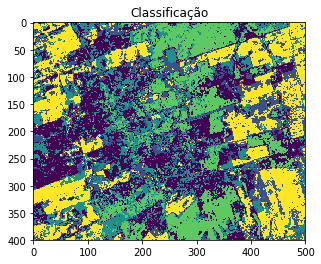

In [17]:
import matplotlib.pyplot as plt
plt.title('Classificação')
plt.imshow(map_class)
plt.colorbar
plt.show()

### Criando a matriz de confusão

**Tabela 1** - Matriz de Confusão
<img src="_trabalho_final_intro/figuras_apresentacao/matriz_confusao.png", width=450, height=450>


In [19]:
##################################### CRIANDO A MATRIZ DE CONFUSÃO #####################################

# construção da matriz de confusão

matrix_confu = np.zeros((nclass, nclass))
cont = 0

# matriz transposta da do envi, saída do programa

for j in range(nclass):
    lim_pxcls = int(pixel_classe[0, j])
    for k in range(lim_pxcls):
        pix_xy = world2Pixel(trans, matriz_shape_tst[cont, 2], matriz_shape_tst[cont, 3])  #chama as coord. xy da imagem
        value_class = int(map_class[pix_xy[0], pix_xy[1]])  #coordenada pix_xy[0] = x e pix_xy[1] = y        
        matrix_confu[j][value_class - 1] = matrix_confu[j][value_class - 1] + 1
        if cont < nlin_tr - 1:
            cont += 1

# matriz de acordo com o envi.

matrix_confu_inv = np.zeros((nclass, nclass))

for j in range(nclass):
    for k in range(nclass):
        matrix_confu_inv[j][k] = matrix_confu[k][j]

### Calculando o Índice de kappa e acurácias

Índice de kappa é dado por: $\kappa = \frac{P_{o} - P_{c}}{1 - P_{c}}$
<br>
<br>
Em que: $P_{o} = \frac{\sum_{i=1}^{\kappa}n_{ii}}{N}$ e $P_{c} = \frac{\sum_{i=1}^{\kappa}n_{i+}n_{+i}}{N^2}$. 
<br>
<br>
$P_{o}$ é conhecido como Acurácia global.
<br>
<br>
Exatidão Global: $P_{o} = \frac{\sum_{i=1}^{\kappa}n_{ii}}{N} * 100$
<br>
<br>
Acurácia do usuário: $au_{i} = \frac{n_{ii}}{n_{i+}}$
<br>
<br>
Acurácia do produtor: $ap_{i} = \frac{n_{ii}}{n_{+i}}$


In [37]:
##################################### CALCULANDO O ÍNDICE DE KAPPA E ACURÁCIAS #####################################

# construção do índice kappa
soma = 0  # valor total de pixel da amostras de teste
cont1 = 0

vet_col = np.zeros((1, nclass))
vet_lin = np.zeros((1, nclass))
sum_diag = 0
diag = np.zeros((1, nclass))

for k in range(nclass):
    soma = soma + pixel_classe[0, k]

# somando as linhas da matriz
for i in range(nclass):
    for j in range(nclass):
        cont1 = cont1 + matrix_confu[i][j]
        if i == j:
            sum_diag = sum_diag + matrix_confu[i][j]
            diag[0][i] = matrix_confu[i][j]

    vet_lin[0, i] = cont1
    cont1 = 0

# somando as colunas da matriz
for i in range(nclass):
    for j in range(nclass):
        cont1 = cont1 + matrix_confu[j][i]
    vet_col[0, i] = cont1
    cont1 = 0

# calculando a acurácia global
po = sum_diag / soma
ac_global = po * 100  # acurácia global

pc = (sum(vet_col * vet_lin)) / (soma ** 2)

kappa = (po - pc) / (1 - pc)

# calculando a acurácia do usuário
ac_usuario = (diag / vet_col) * 100

# calculando a acurácia do produtor
ac_produtor = (diag / vet_lin) * 100

### Salvando o resultado em txt

In [21]:
###################################### SALVANDO O RESULTADO EM TXT ######################################

num_arq = 0 # variável que modifica o nome do arquivo de saída.

# Acessando o diretório onde estão salvas as imagens
os.chdir(os.path.join(os.getcwd(), 'C:/Users/Maria/_trabalho_final_intro/imagens'))
os.getcwd()

# Criando lista com os nomes das imagens acessadas no diretório
lista_nomes = os.listdir(os.getcwd())
nome_arq = []

for dados in lista_nomes:
    if dados[-3:] == 'tif':
        nome_arq2 = nome_arq.append(dados[:-4])

#-----------------        

# salvando a matriz em arquivo txt
vet_ = np.zeros((1, nclass))
for i in range(nclass):
    vet_[0][i] = i + 1

with open('C:/Users/Maria/_trabalho_final_intro/saida_txt/result.txt', "w", encoding='utf-8') as out_file:    
    for i in range(len(vet_)):
        out_string = ""
        out_file.write(out_string)
        out_string += str(vet_[i])
        out_file.write(out_string)
    out_string = ("\n")
    out_file.write(out_string)
    for i in range(len(matrix_confu_inv)):
        out_string = ""
        out_string += str(i + 1)
        out_string += str(matrix_confu_inv[i])   
        out_string += "\n"
        out_file.write(out_string)
    out_string = ("\n")
    out_file.write(out_string)
    out_string = ("Kappa: ")
    out_file.write(out_string)
    out_string = str(kappa)   
    out_file.write(out_string)
    out_string = ("\n")
    out_file.write(out_string)
    out_string = ("Acurácia Global: ")
    out_file.write(out_string)
    out_string = str(ac_global)
    out_file.write(out_string)
    out_string = ("\n")
    out_file.write(out_string)
    out_string = ("Acurácia do usuário: ")
    out_file.write(out_string)    
    for i in range(len(ac_usuario)):
        out_string = ""
        out_string += str(ac_usuario[i])
        out_string += "\n"
        out_file.write(out_string)
    out_string = ("Acurácia do produtor: ")
    out_file.write(out_string)
    for i in range(len(ac_produtor)):
        out_string = ""
        out_string += str(ac_produtor[i])
        out_string += "\n"
        out_file.write(out_string)

### Salvando a classificação em formato tiff

In [22]:
###################################### SALVANDO A CLASSIFICAÇÃO EM TIFF ######################################
# obter metadados
linhas = img.RasterYSize
colunas = img.RasterXSize
bandas = 1

#salvar a banda em GeoTIFF
# definir o nome aquivo
filename_output = "C:/Users/Maria/_trabalho_final_intro/saida_classificacao/classif_mxv4_5b_B2457e8_500x400.tif"
# definir driver
driver = gdal.GetDriverByName('GTiff')
# copiar tipo de dados da banda já existente
data_type = gdal.GDT_Int16
# criar novo dataset
dataset_output = driver.Create(filename_output, colunas, linhas, bandas, data_type)
# copiar informações espaciais da banda já existente
dataset_output.SetGeoTransform(img.GetGeoTransform())
# copiar informações de projeção
dataset_output.SetProjection(img.GetProjectionRef())
# escrever dados da matriz mxv na banda
dataset_output.GetRasterBand(1).WriteArray(map_class)
# salvar valores
dataset_output.FlushCache()
# fechar dataset
dataset_output = None

In [23]:
############################################# LIBERANDO MEMÓRIA #############################################
    
#fenchando as imagens para liberar memória
img = None  